In [201]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

from learning_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

import mxnet as mx

from joblib import Parallel, delayed
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
stack = 'MD594'

In [203]:
DataManager.get_image_dimension(stack)

(17408, 11776)

In [22]:
label_gridIndices = locate_annotated_patches_v2(stack=stack, annotation_rootdir=annotation_midbrainIncluded_v2_rootdir)

22 patches in VCA
253 patches in VCA_surround
20706 patches in bg
66 patches in VCA
314 patches in VCA_surround
26386 patches in bg
145 patches in VCA
514 patches in VCA_surround
18369 patches in bg
237 patches in VCA
733 patches in VCA_surround
21599 patches in bg
346 patches in VCA
437 patches in VCA_surround
25468 patches in bg
422 patches in VCA
667 patches in VCA_surround
24226 patches in bg
514 patches in VCA
815 patches in VCA_surround
23704 patches in bg
535 patches in VCA
538 patches in VCA_surround
25579 patches in bg
569 patches in VCA
946 patches in VCA_surround
23084 patches in bg
599 patches in VCA
1066 patches in VCA_surround
20927 patches in bg
633 patches in VCA
1061 patches in VCA_surround
21123 patches in bg
118 patches in VCP
675 patches in VCA
11 patches in DC
386 patches in VCP_surround
1065 patches in VCA_surround
539 patches in DC_surround
22226 patches in bg
136 patches in VCP
646 patches in VCA
84 patches in DC
399 patches in VCP_surround
1032 patches in VCA_s

In [24]:
label_gridIndices

,94,95,96,97,98,99,100,101,102,103,...,354,355,356,357,358,359,360,361,362,363
10N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10N_surround,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12N_surround,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3N_surround,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4N_surround,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5N_surround,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
num_samples_per_landmark = 100
num_samples_per_polygon = None

# num_samples_per_polygon = 10
# num_samples_per_polygon = 9999

In [205]:
all_names = list(label_gridIndices.index)

In [ ]:
structures_to_extract = ['5N', '7N', '7n', 'Pn', 'RtTg', 'VLL', 'SNR', 'SNC', 'SC', 'IC', 'DC', '8n', 'LSO', 'Amb', 
                        'LRt', 'LC', 'Tz', 'R', '6N', '12N', '10N', '3N', '4N', 'IO', 'Sol', 'Gr', 'Cu', 'AP']

In [29]:
structures_to_extract = ['5N', '7N', '7n', 'Pn', 'RtTg', 'VLL', 'Amb', '6N', 'AP', 'LC', 'LRt', 'R', 'Tz', '12N']

In [206]:
structures_to_extract = ['7N']

In [207]:
def sample_locations(grid_indices_lookup, structures, num_samples_per_polygon=None, num_samples_per_landmark=None):

    location_list = defaultdict(list)

    for name in structures:

        if name not in grid_indices_lookup.index:
            continue

        for sec, grid_indices in grid_indices_lookup.loc[name].dropna().to_dict().iteritems():

            n = len(grid_indices)

            if n == 0:
                sys.stderr.write('Cell is empty.\n')
                continue


            if num_samples_per_polygon is None:
                location_list[name] += [(stack, sec, i) for i in grid_indices]

            else:
                random_sampled_indices = grid_indices[np.random.choice(range(n), min(n, num_samples_per_polygon), replace=False)]
                location_list[name] += [(stack, sec, i) for i in random_sampled_indices]

    if num_samples_per_landmark is not None:
        
        sampled_location_list = {}
        for name_s, addresses in location_list.iteritems():
            n = len(addresses)
            random_sampled_indices = np.random.choice(range(n), min(n, num_samples_per_landmark), replace=False)
            sampled_location_list[name_s] = [addresses[i] for i in random_sampled_indices]
        return sampled_location_list
    
    else:
        location_list.default_factory = None
        return location_list
       

In [219]:
location_list = sample_locations(label_gridIndices, structures_to_extract,
                                num_samples_per_landmark=100)

In [220]:
def apply_function_to_dict(func, d):
    """
    Func applies to the list consisting of all elements of d, and return a list.
    """
    result = func(list(chain(*d.values())))
    csum = np.cumsum(map(len, d.values()))
    new_d = {k: result[(0 if i == 0 else csum[i-1]):csum[i]] for i, k in enumerate(d.keys())}  
    return new_d

In [221]:
from functools import partial

patches = apply_function_to_dict(partial(extract_patches_given_locations_multiple_sections, 
                                         location_or_grid_index='index', 
                                         version='rgb-jpg'), 
                                 location_list)

In [222]:
def random_choice(arr, n, return_indices=False):
    m = len(arr)
    sampled_indices = np.random.choice(range(m), min(10, m), replace=False)
    sampled_arr = [arr[i] for i in sampled_indices]
    if return_indices:
        return sampled_arr, sampled_indices
    else:
        return sampled_arr

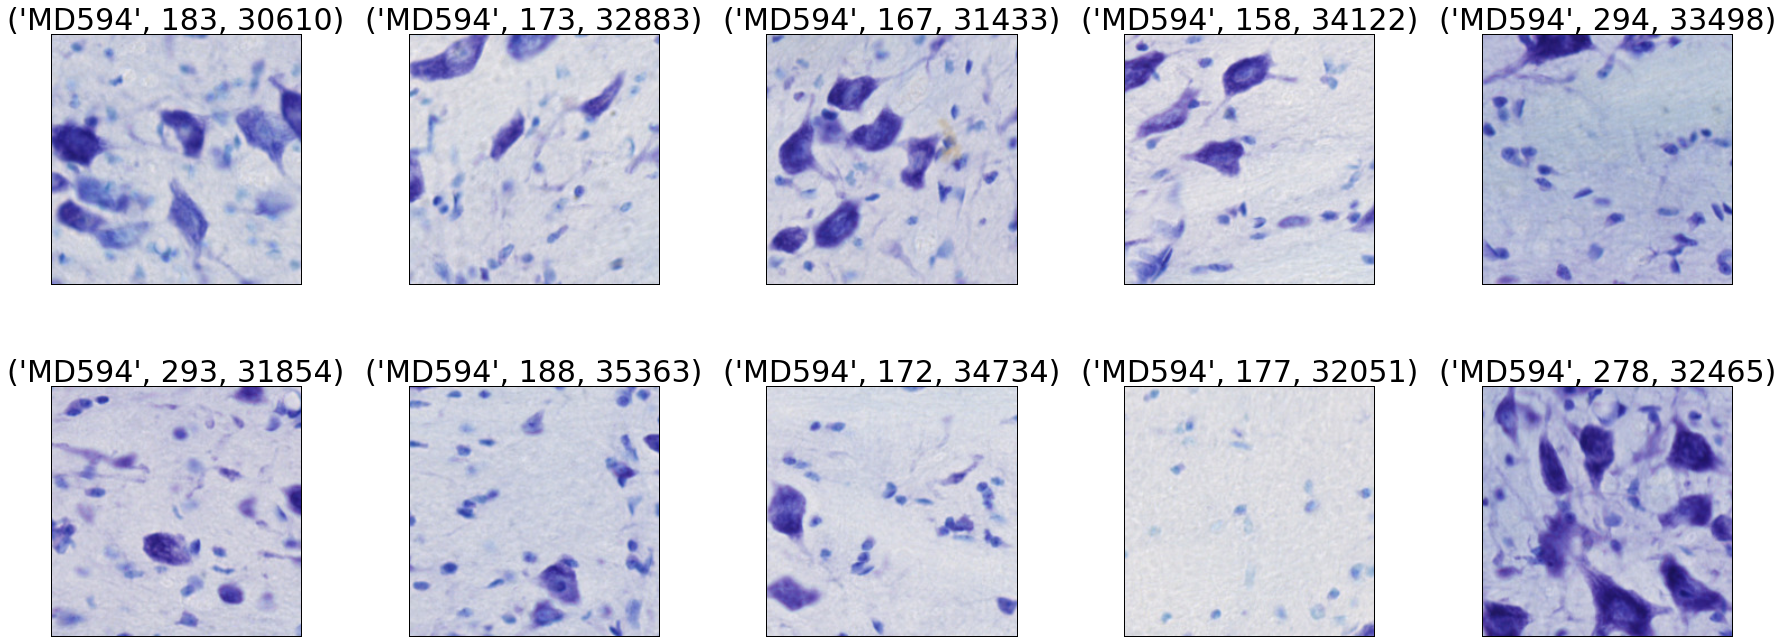

In [228]:
for name, patches_this_name in patches.iteritems():
    random_patches, random_indices = random_choice(patches_this_name, 10, return_indices=True)
    display_images_in_grids(random_patches, nc=5, titles=[location_list[name][i] for i in random_indices])

In [229]:
patch_size, stride, _, _ = get_default_gridspec('MD594')

In [232]:
viz = patch_boxes_overlay_on('original', 4, 
                             [[grid_locations[idx] for st, sec, idx in locations if sec == 188] 
                              for locations in location_list.values()],
                      patch_size=patch_size,
                      stack='MD594',
                       sec=188)

In [233]:
display_image(viz)

/home/yuncong/Brain/learning/tmp.jpg

In [ ]:
# stack_section_list = set([(stk, sec) for name, loc_list in location_list.iteritems() for stk, sec, ind in loc_list ])

In [ ]:
# indices_locations_dict = {(stack, sec): np.loadtxt('/home/yuncong/CSHL_patch_locations/%(stack)s/%(stack)s_%(sec)04d_roi1_indices_locations.txt' % \
#                                                    {'stack':stack, 'sec':sec}, dtype=np.int)
#                           for stk, sec in stack_section_list}

In [ ]:
from itertools import groupby

In [ ]:
def load_dnn_features(addresses):
    """
    addresses: list of (stack, section, grid_index)
    """
    
    addresses_with_index = [x + (i,) for i, x in enumerate(addresses)]
    
    index_feature_tuple_list = []
    for stack_section, addresses_this_group in groupby(addresses_with_index, lambda x: (x[0], x[1])):
    
        stack, sec = stack_section
    
        gridIndex_location_list = np.loadtxt('/home/yuncong/CSHL_patch_locations/%(stack)s/%(stack)s_%(sec)04d_roi1_indices_locations.txt' % \
                                                       {'stack':stack, 'sec':sec}, dtype=np.int)

        feature_list_curr_section = load_hdf('/home/yuncong/CSHL_patch_features_Sat16ClassFinetuned/%(stack)s/%(stack)s_%(sec)04d_roi1_features.hdf' % \
                                                       {'stack':stack, 'sec':sec})
        
        gridIndex_list = [ind for ind, x, y in gridIndex_location_list]
        index_feature_tuples = [(ind, feature_list_curr_section[gridIndex_list.index(grid_ind)]) for _, _, grid_ind, ind in addresses_this_group]
        index_feature_tuple_list += index_feature_tuples
    
    features_list_originalOrder = [f for i, f in sorted(index_feature_tuple_list)]
    return features_list_originalOrder

In [ ]:
features = apply_function_to_dict(load_dnn_features, location_list)

In [ ]:
## load
patches_allClasses = {}

for l in labels_surroundIncluded:
    print l
    vs = load_hdf(training_patches_dir + '/%(stack)s_%(label)s.hdf' % {'stack':stack, 'label':l})
    patches_allClasses[l] = vs

In [ ]:
## save
for l, vs in patches_allClasses_sat.iteritems():
    save_hdf(vs, training_patches_dir + '/%(stack)s_%(label)s_sat.hdf' % {'stack':stack, 'label':l})

In [ ]:
## load
patches_allClasses_sat = {}

for l in labels_surroundIncluded:
    print l
    vs = load_hdf(training_patches_dir + '/%(stack)s_%(label)s_sat.hdf' % {'stack':stack, 'label':l})
    patches_allClasses_sat[l] = vs

In [ ]:
# patches_allClasses_reshaped = dict([( l, np.rollaxis(patches, 3, 1) ) 
#                                     for l, patches in patches_allClasses.iteritems()])

In [ ]:
patches_allClasses_sat_reshaped = dict([(l, patches[:,None,:,:] ) 
                                        for l, patches in patches_allClasses_sat.iteritems()])

In [ ]:
class_len = dict(sorted([(label, len(patches)) for label, patches in patches_allClasses.iteritems()]))
print class_len

In [ ]:
model_name='inception-stage1'
model_iteration = 10
init_model = mx.model.FeedForward.load(os.path.join(model_dir, model_name), 
                                     model_iteration, 
                                     ctx=mx.gpu())

arg_params = init_model.arg_params.copy()
arg_params.pop('fullc_bias');
arg_params.pop('fullc_weight');
arg_params['conv_1_weight'] = init_model.arg_params['conv_1_weight'].asnumpy()[:,[0],:,:]

flatten_output = init_model.symbol.get_internals()['flatten_output']

model = mx.model.FeedForward(ctx=mx.gpu(), symbol=flatten_output, num_epoch=model_iteration,
                            arg_params=init_model.arg_params, aux_params=init_model.aux_params,
                            allow_extra_params=True)

In [ ]:
# mean_img = mx.nd.load(os.path.join(model_dir, 'mean_224.nd'))['mean_img'].asnumpy()[0]

In [ ]:
# dm.set_slice(160)

# img_hsv = rgb2hsv(dm.image_rgb_jpg[1500:1600, 1500:1600])

# fig, axes = plt.subplots(3, 2, figsize=(2*3, 3*3))
# axes[0, 0].imshow(img_hsv[..., 0], cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[0, 0].set_title('hue');
# axes[0, 1].imshow(rescale_intensity(img_hsv[..., 0]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[0, 1].set_title('rescaled hue');
# axes[1, 0].imshow((1-img_hsv[..., 1]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[1, 0].set_title('saturation');
# axes[1, 1].imshow(rescale_intensity(1-img_hsv[..., 1]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[1, 1].set_title('rescaled saturation');
# axes[2, 0].imshow(img_hsv[..., 2], cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[2, 0].set_title('value');
# axes[2, 1].imshow(rescale_intensity(img_hsv[..., 2]), cmap=plt.cm.gray, vmin=0, vmax=1);
# axes[2, 1].set_title('rescaled value');

In [ ]:
img_sat = patches_allClasses_sat['sp5'][np.random.randint(len(patches_allClasses_sat['sp5']))]
# img_sat = patches_allClasses_sat_concatenated[np.random.randint(patches_allClasses_sat_concatenated.shape[0])]
plt.imshow(img_sat, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.colorbar();

In [ ]:
mean_img = np.load(model_dir + '/saturation_mean_224.npy')

plt.imshow(mean_img, cmap=plt.cm.gray, vmin=0, vmax=255);
plt.title('mean image');
plt.colorbar();

In [ ]:
patches_allClasses_normalized = dict([(label, patches - mean_img) 
                                      for label, patches in patches_allClasses_sat_reshaped.iteritems()])

In [ ]:
model_name = 'Sat16ClassFinetuned'
model_iteration = 10

model = mx.model.FeedForward.load(os.path.join(model_dir, model_name), model_iteration, ctx=mx.gpu())

flatten_output = model.symbol.get_internals()['flatten_output']

model = mx.model.FeedForward(ctx=mx.gpu(), symbol=flatten_output, num_epoch=model_iteration,
                            arg_params=model.arg_params, aux_params=model.aux_params,
                            allow_extra_params=True)

In [ ]:
training_features_dir = '/home/yuncong/CSHL_patch_features_%(model_name)s/train_v3' % {'model_name': model_name}
create_if_not_exists(training_features_dir)

In [ ]:
for label, patches in patches_allClasses_normalized.iteritems():
    
    print label
    
    n = len(patches)
    
#     batch_size = 512 # increasing to 892 does not save any time
    batch_size = min(class_len.values())

    if n < batch_size:
        sys.stderr.write('data size smaller than batch size: %s\n' % label)
        continue
    
    train_iter = mx.io.NDArrayIter(
        patches, 
        np.zeros((n, ), np.int),
        batch_size=batch_size,
        shuffle=False
    )

    t = time.time()

    features = model.predict(train_iter)

    save_hdf(features, training_features_dir + '/%(stack)s_%(label)s_features.hdf' % \
             {'stack': stack, 'label': label})
    
    sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t)) # ~ 3s/class (sample per polygon 10)